In [1]:
import numpy as np
import xarray as xr
import scipy.stats as st
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import requests
import os,errno
import sys
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER,LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
import datetime as dt
import pandas as pd
import time
import urllib.request
import metpy.calc as mpcalc
import salem
import scipy.optimize as opt
import warnings
import geopy.distance
import matplotlib as mpl
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
import matplotlib.backends.backend_pdf

from scipy.ndimage.measurements import label
from scipy.ndimage import binary_dilation

warnings.filterwarnings('ignore')

%matplotlib inline

dir_data='/Users/ahenny/'
dir1='/Volumes/LaCie/'
dir2='/Volumes/Extreme Pro/'
dir3='/Volumes/My Passport/day/'

/var/folders/6s/v2ptr27x1537n4_9dh_x4n0h0000gq/T/ipykernel_40740/1809499068.py:26: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import label


In [4]:
ds=xr.open_dataset('/Users/ahenny/Downloads/REGEN_AllStns_V1-2019_1950-2016_QualityMask.nc')
quality=ds['p']

lons_east=[x for x in quality.lon.values if x>=90]
lons_west=[x for x in quality.lon.values if x<-90]
q_east=quality.sel(lon=lons_east)
q_west=quality.sel(lon=lons_west)
q_east['lon']=[x-360. for x in lons_east]
q_west['lon']=[x+360. for x in lons_west]
quality=xr.concat([q_east,quality,q_west],dim='lon')
print(quality)

<xarray.DataArray 'p' (lat: 180, lon: 540)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 -269.5 -268.5 -267.5 -266.5 ... 267.5 268.5 269.5
Attributes:
    units:          1
    long_name:      boolean mask for REGEN precipitation V1.0
    standard_name:  status_flag
    flag_values:    [-99999      0      1]
    flag_meanings:  ocean land_low_quality land_high_quality


In [19]:
yrs=np.arange(1997,2023,1)

for i in range(len(yrs)):
    year=yrs[i]
    print(year)
    ds=xr.open_dataset(dir_data+'holding/'+'gpcp_precip_'+str(year)+'.nc')
    precip=ds['precip']
    
    precip=precip.interp_like(quality)
    precip=precip.where(quality==1)
    lons_globe=[x for x in quality.lon.values if -180<=x<180]
    precip=precip.sel(lon=lons_globe)
    
    defined1=xr.ones_like(precip).sum(dim='time')
    defined=xr.ones_like(precip).where(precip.round(2)>=0).sum(dim='time')
    
    print(defined.mean().values.tolist())
    
    if i==0:
        max_concat=defined1
        present_concat=defined
    else:
        max_concat=xr.concat([max_concat,defined1],dim='time')
        present_concat=xr.concat([present_concat,defined],dim='time')

1997
46.78533950617284
1998
46.785262345679016
1999
46.78533950617284
2000
46.90751543209876
2001
46.74010802469136
2002
46.6133950617284
2003
46.72625
2004
46.86229938271605
2005
46.78533950617284
2006
46.78533950617284
2007
46.78533950617284
2008
46.913518518518515
2009
46.78533950617284
2010
45.50279320987654
2011
46.785308641975305
2012
46.913518518518515
2013
46.66746913580247
2014
46.29780864197531
2015
46.78533950617284
2016
46.66373456790124
2017
46.785324074074076
2018
46.78489197530864
2019
46.78533950617284
2020
45.542175925925925
2021
46.33399691358024
2022
44.82743827160494


In [21]:
max_all=max_concat.sum(dim='time')
present_all=present_concat.sum(dim='time')
ratio_all=present_all/max_all

In [33]:
yrs=np.arange(1997,2023,1)

ds=xr.open_dataset(dir_data+'gpcp_threshold_final_98_all.nc')
#ds=xr.open_dataset(dir_data+'gpcp_threshold_r95p.nc')
lats_sel=[x for x in present_concat.lat.values if -60<=x<=70]
threshold=ds['threshold'].interp_like(quality).sel(lat=lats_sel,lon=lons_globe)
ratio_all=ratio_all.sel(lat=lats_sel)

if 1==1:
    total_list_land=[]
    freq_list_land=[]
    intensity_list_land=[]
    
    total_list_ocean=[]
    freq_list_ocean=[]
    intensity_list_ocean=[]
    
    total_ocean_monthly=np.zeros((12,len(yrs)))
    freq_ocean_monthly=np.zeros((12,len(yrs)))
    intensity_ocean_monthly=np.zeros((12,len(yrs)))
    
    total_land_monthly=np.zeros((12,len(yrs)))
    freq_land_monthly=np.zeros((12,len(yrs)))
    intensity_land_monthly=np.zeros((12,len(yrs)))

for i in range(len(yrs)):
    year=yrs[i]
    print(year)
    factor=1.
        
    ds=xr.open_dataset(dir_data+'holding/'+'gpcp_precip_'+str(year)+'.nc')
    precip=ds['precip']#.sel(lat=lats_sel)
    
    precip=precip.interp_like(quality)
    precip=precip.sel(lat=lats_sel,lon=lons_globe)
    
    weights=np.cos(np.deg2rad(precip.lat))

    if i==0:#land mask option
        ds=xr.open_dataset('/Users/ahenny/Downloads/data.nc')
        t2m=ds['t2m'][0,:,:]
        land_mask=t2m/t2m
        land_mask=land_mask.fillna(0)
        
        lon_east=[x for x in land_mask.longitude.values if x>=180.]
        lon_west=[x for x in land_mask.longitude.values if x<180.]
        l_east=land_mask.sel(longitude=lon_east)
        l_west=land_mask.sel(longitude=lon_west)
        l_east['longitude']=[x-360. for x in lon_east]
        land_mask=xr.concat([l_east,l_west],dim='longitude')
        
        dk=xr.Dataset()
        dk['land']=(('lat','lon'),land_mask.values)
        dk.coords['lat']=land_mask.latitude.values
        dk.coords['lon']=land_mask.longitude.values
        
        land_mask=dk['land']
        land_mask_interp=land_mask.interp_like(precip[0,:,:])
        
    defined1=xr.ones_like(precip).sum(dim='time').where(land_mask_interp>=0.5).where(quality==1)
    defined=xr.ones_like(precip).where(precip.round(2)>=0).sum(dim='time').where(land_mask_interp>=0.5).where(quality==1)
    ratio_land=defined/defined1
    valid_area_land=xr.ones_like(precip).where(ratio_land>=0.9).fillna(0).where(land_mask_interp>=0.5).where(quality==1).weighted(weights).mean().values.tolist()
    
    defined1=xr.ones_like(precip).sum(dim='time').where(land_mask_interp<0.5)
    defined=xr.ones_like(precip).where(precip.round(2)>=0).sum(dim='time').where(land_mask_interp<0.5)
    ratio_ocean=defined/defined1
    valid_area_ocean=xr.ones_like(precip).where(ratio_ocean>=0.9).fillna(0).where(land_mask_interp<0.5).weighted(weights).mean().values.tolist()
    
    print((valid_area_land,valid_area_ocean))

    if 1==1:
        threshold_new=xr.zeros_like(precip)
        for k in range(threshold_new.time.size):
            date=pd.to_datetime(threshold_new.time.values[k])
            if date.month==2 and date.day==29:
                threshold_new1=threshold.sel(time=dt.datetime(1997,2,28))
                threshold_new2=threshold.sel(time=dt.datetime(1997,3,1))
                threshold_new3=(threshold_new1+threshold_new1)/2.
            else:
                threshold_new3=threshold.sel(time=dt.datetime(1997,date.month,date.day))

            threshold_new[k,:,:]=threshold_new3.values
    if 1==0:
        threshold_new=threshold
        
    precip_extreme=precip.where(precip>=1.)
    #precip_extreme=precip_extreme.where(precip_extreme>=threshold_new)
    
    #OCEAN
    
    ones=precip_extreme/precip_extreme
    freq=ones.sum(dim='time',skipna=True).fillna(0).where(land_mask_interp<0.5).where(ratio_all>=0.9).where(ratio_ocean>=0.9)/ratio_ocean
    extreme_sum=precip_extreme.sum(dim='time',skipna=True).fillna(0).where(land_mask_interp<0.5).where(ratio_all>=0.9).where(ratio_ocean>=0.9)/ratio_ocean
    #freq=ones.sum(dim='time',skipna=True).fillna(0).where(land_mask_interp<0.5)
    #extreme_sum=precip_extreme.sum(dim='time',skipna=True).fillna(0).where(land_mask_interp<0.5)
    
    weights=np.cos(np.deg2rad(extreme_sum.lat))
    total_weighted=extreme_sum.weighted(weights)
    freq_weighted=freq.weighted(weights)
    weighted_1=precip_extreme.where(land_mask_interp<0.5).where(ratio_all>=0.9).where(ratio_ocean>=0.9).weighted(weights)
    #weighted_1=precip_extreme.where(land_mask_interp<0.5).weighted(weights)
    intensity=weighted_1.mean(skipna=True).values.tolist()
    
    if valid_area_ocean>=0.9:
    #if 1==1:
        total_list_ocean.append(total_weighted.mean(dim=('lat','lon'),skipna=True).values.tolist()*factor)
        freq_list_ocean.append(freq_weighted.mean(dim=('lat','lon'),skipna=True).values.tolist()*factor)
        intensity_list_ocean.append(intensity)
    else:
        total_list_ocean.append(np.nan)
        freq_list_ocean.append(np.nan)
        intensity_list_ocean.append(np.nan)

    for j in range(12):
        dates=[x for x in ones.time.values if pd.to_datetime(x).month==j+1]
        precip_sel=precip.sel(time=dates)
        defined1=xr.ones_like(precip_sel).sum(dim='time').where(land_mask_interp<0.5)
        defined=xr.ones_like(precip_sel).where(precip_sel.round(2)>=0).sum(dim='time').where(land_mask_interp<0.5)
        ratio=defined/defined1
        valid_area=xr.ones_like(precip_sel).where(ratio>=0.9).fillna(0).where(land_mask_interp<0.5).weighted(weights).mean().values.tolist()
    
        field=precip_extreme.sel(time=dates)
        extreme_sum=field.sum(dim='time',skipna=True).fillna(0).where(land_mask_interp<0.5).where(ratio_all>=0.9).where(ratio>=0.9)/ratio
        #extreme_sum=field.sum(dim='time',skipna=True).fillna(0).where(land_mask_interp<0.5)
        total_weighted=extreme_sum.weighted(weights)
        total_mean=total_weighted.mean(dim=('lat','lon'),skipna=True).values.tolist()

        field=ones.sel(time=dates)
        ones_sum=field.sum(dim='time',skipna=True).fillna(0).where(land_mask_interp<0.5).where(ratio_all>=0.9).where(ratio>=0.9)/ratio
        #ones_sum=field.sum(dim='time',skipna=True).fillna(0).where(land_mask_interp<0.5)
        freq_weighted=ones_sum.weighted(weights)
        freq_mean=freq_weighted.mean(dim=('lat','lon'),skipna=True).values.tolist()
        
        field=precip_extreme.sel(time=dates)
        intensity_weighted=field.where(land_mask_interp<0.5).where(ratio_all>=0.9).where(ratio>=0.9).weighted(weights)
        #intensity_weighted=field.where(land_mask_interp<0.5).weighted(weights)
        intensity_mean=intensity_weighted.mean(skipna=True).values.tolist()
        
        if valid_area>=0.9:
            total_ocean_monthly[j,i]=total_mean*factor
            freq_ocean_monthly[j,i]=freq_mean*factor
            intensity_ocean_monthly[j,i]=intensity_mean
        else:
            total_ocean_monthly[j,i]=np.nan
            freq_ocean_monthly[j,i]=np.nan
            intensity_ocean_monthly[j,i]=np.nan
    
    #LAND
    
    freq=ones.sum(dim='time',skipna=True).fillna(0).where(land_mask_interp>=0.5).where(ratio_all>=0.9).where(ratio_land>=0.9).where(quality==1)/ratio_land
    extreme_sum=precip_extreme.sum(dim='time',skipna=True).fillna(0).where(land_mask_interp>=0.5).where(ratio_all>=0.9).where(ratio_land>=0.9).where(quality==1)/ratio_land
    #freq=ones.sum(dim='time',skipna=True).fillna(0).where(land_mask_interp>=0.5)
    #extreme_sum=precip_extreme.sum(dim='time',skipna=True).fillna(0).where(land_mask_interp>=0.5)
    
    weights=np.cos(np.deg2rad(extreme_sum.lat))
    total_weighted=extreme_sum.weighted(weights)
    freq_weighted=freq.weighted(weights)
    weighted_1=precip_extreme.where(land_mask_interp>=0.5).where(ratio_all>=0.9).where(ratio_land>=0.9).where(quality==1).weighted(weights)
    #weighted_1=precip_extreme.where(land_mask_interp>=0.5).weighted(weights)
    intensity=weighted_1.mean(skipna=True).values.tolist()
    
    if valid_area_land>=0.9:
    #if 1==1:
        print(total_weighted.mean(dim=('lat','lon'),skipna=True).values.tolist()*factor)
        total_list_land.append(total_weighted.mean(dim=('lat','lon'),skipna=True).values.tolist()*factor)
        freq_list_land.append(freq_weighted.mean(dim=('lat','lon'),skipna=True).values.tolist()*factor)
        intensity_list_land.append(intensity)
    else:
        total_list_land.append(np.nan)
        freq_list_land.append(np.nan)
        intensity_list_land.append(np.nan)

    for j in range(12):
        dates=[x for x in ones.time.values if pd.to_datetime(x).month==j+1]
        precip_sel=precip.sel(time=dates)
        defined1=xr.ones_like(precip_sel).sum(dim='time').where(land_mask_interp>=0.5).where(quality==1)
        defined=xr.ones_like(precip_sel).where(precip_sel.round(2)>=0).sum(dim='time').where(land_mask_interp>=0.5).where(quality==1)
        ratio=defined/defined1
        valid_area=xr.ones_like(precip_sel).where(ratio>=0.9).fillna(0).where(land_mask_interp>=0.5).where(quality==1).weighted(weights).mean().values.tolist()
        
        field=precip_extreme.sel(time=dates)
        extreme_sum=field.sum(dim='time',skipna=True).fillna(0).where(land_mask_interp>=0.5).where(ratio_all>=0.9).where(quality==1).where(ratio>=0.9)/ratio
        #extreme_sum=field.sum(dim='time',skipna=True).fillna(0).where(land_mask_interp>=0.5)
        total_weighted=extreme_sum.weighted(weights)
        total_mean=total_weighted.mean(dim=('lat','lon'),skipna=True).values.tolist()

        field=ones.sel(time=dates)
        ones_sum=field.sum(dim='time',skipna=True).fillna(0).where(land_mask_interp>=0.5).where(ratio_all>=0.9).where(quality==1).where(ratio>=0.9)/ratio
        #ones_sum=field.sum(dim='time',skipna=True).fillna(0).where(land_mask_interp>=0.5)
        freq_weighted=ones_sum.weighted(weights)
        freq_mean=freq_weighted.mean(dim=('lat','lon'),skipna=True).values.tolist()

        field=precip_extreme.sel(time=dates)
        intensity_weighted=field.where(land_mask_interp>=0.5).where(ratio_all>=0.9).where(ratio>=0.9).where(quality==1).weighted(weights)
        #intensity_weighted=field.where(land_mask_interp>=0.5).weighted(weights)
        intensity_mean=intensity_weighted.mean(skipna=True).values.tolist()
        
        if valid_area>=0.9:
            total_land_monthly[j,i]=total_mean*factor
            freq_land_monthly[j,i]=freq_mean*factor
            intensity_land_monthly[j,i]=intensity_mean
        else:
            total_land_monthly[j,i]=np.nan
            freq_land_monthly[j,i]=np.nan
            intensity_land_monthly[j,i]=np.nan

1997
(0.9998541854492318, 0.9962118351635973)
756.2592766975455
1998
(0.9998541854492318, 0.9962118351635973)
797.5035385269332
1999
(0.9998541854492318, 0.9962118351635973)
755.9697350868903
2000
(0.9998541854492319, 0.9962118351635966)
796.8718267398032
2001
(0.9998541854492318, 0.9962118351635973)
738.6909336989362
2002
(0.9998541854492318, 0.9962118351635973)
740.7883997368908
2003
(0.9998541854492318, 0.9962118351635973)
737.464908850418
2004
(0.9998541854492319, 0.9962118351635966)
781.9349376355556
2005
(0.9998541854492318, 0.9962118351635973)
744.7073427765993
2006
(0.9998541854492318, 0.9962118351635973)
757.6314072968761
2007
(0.9998541854492318, 0.9962118351635973)
753.4434840976868
2008
(0.9998541854492319, 0.9962118351635966)
767.7339548161913
2009
(0.9998541854492318, 0.9962118351635973)
761.4397568224057
2010
(0.9998541854492318, 0.9962118351635973)
806.1907023251168
2011
(0.9998541854492318, 0.9962118351635973)
771.4757300151034
2012
(0.9998541854492319, 0.9962118351635

In [34]:
dk=xr.Dataset()
dk['total_list_gpcp_ocean']=(('years'),total_list_ocean)
dk['freq_list_gpcp_ocean']=(('years'),freq_list_ocean)
dk['intensity_list_gpcp_ocean']=(('years'),intensity_list_ocean)

dk['total_list_gpcp_land']=(('years'),total_list_land)
dk['freq_list_gpcp_land']=(('years'),freq_list_land)
dk['intensity_list_gpcp_land']=(('years'),intensity_list_land)

dk['total_gpcp_ocean_monthly']=(('months','years'),total_ocean_monthly)
dk['freq_gpcp_ocean_monthly']=(('months','years'),freq_ocean_monthly)
dk['intensity_gpcp_ocean_monthly']=(('months','years'),intensity_ocean_monthly)

dk['total_gpcp_land_monthly']=(('months','years'),total_land_monthly)
dk['freq_gpcp_land_monthly']=(('months','years'),freq_land_monthly)
dk['intensity_gpcp_land_monthly']=(('months','years'),intensity_land_monthly)

dk.coords['years']=np.arange(1997,2023,1)
dk.coords['months']=np.arange(12)

try:
    os.remove(dir_data+'precip_datasets_compare_gpcp_wet_6070_HQ.nc')
except OSError:
    pass
dk.to_netcdf(dir_data+'precip_datasets_compare_gpcp_wet_6070_HQ.nc',mode='w',format='NETCDF4')

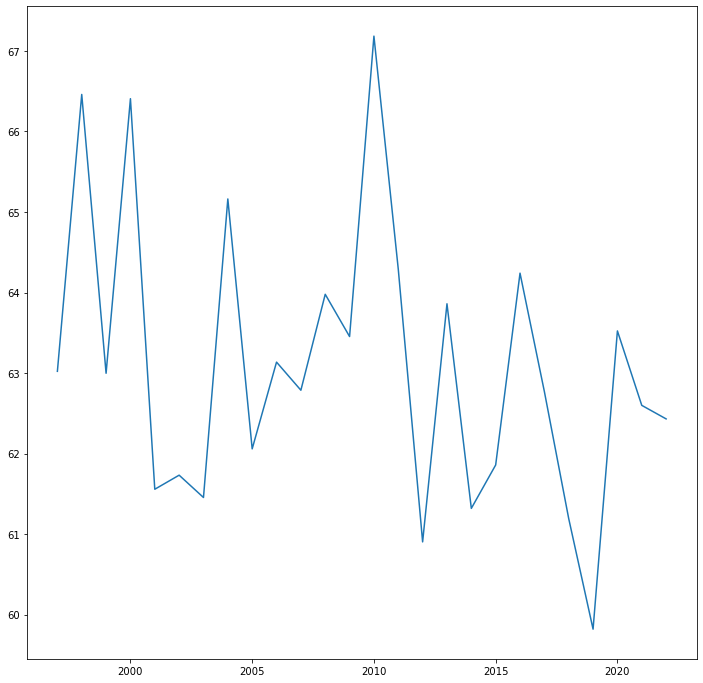

In [35]:
fig=plt.figure(figsize=(12,12))
ax=plt.subplot(1,1,1)
ax.plot(yrs,[x/12. for x in total_list_land])
plt.show()